# PCA Interpretation

In this notebook, we will follow the work in `./model/visualization/pca_visualization.ipynb` and inspect the actual samples in PCA hidden space in hope of interpreting our detector and understand what corpus is considered as "more GPT-like" and what corpus is considered as "more humanized"

## Initialization

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from transformers import RobertaModel, RobertaTokenizer
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

from Model import SentinelNonLinear
from Dataset import DualDataset

random.seed(29)

Setup paths used by this notebook. (Change them if you want / need!)

In [2]:
PATH_ROOT = Path(Path.cwd().parent.parent.parent)
PATH_WEBTEXT = Path(PATH_ROOT, "data", "open-web-text-final")
PATH_GPTTEXT = Path(PATH_ROOT, "data", "open-gpt-text-final")
PATH_DIRTY_WEB = Path(PATH_ROOT, "data", "open-web-text")
PATH_DIRTY_GPT = Path(PATH_ROOT, "data", "open-gpt-text")

PATH_CACHE = Path(PATH_ROOT, "result", "cache")
PATH_CLEAN_CHECKPT = Path(PATH_CACHE, "roberta.base.0425.pt")
PATH_DIRTY_CHECKPT = Path(PATH_CACHE, "roberta.base.0420.pt")

PATH_FIG = Path(PATH_ROOT, "result", "figures", "interp")
PATH_TXT = Path(PATH_ROOT, "result", "text")

Since we are following the work in `pca_visualization.ipynb`, we assume the cached files already exist. If not, run that notebook first and it will generate all required cache files automatically.

> Notation (var names): `c` = Clean, `d` = Dirty.
> 
> `cmcd` = Clean Model Clean Data
> 
> `dmdd` = Dirty Model Dirty Data

In [3]:
PATH_CMCD = Path(PATH_CACHE, "clean_model_clean_data_hidden.pt")
PATH_CMDD = Path(PATH_CACHE, "clean_model_dirty_data_hidden.pt")
PATH_DMCD = Path(PATH_CACHE, "dirty_model_clean_data_hidden.pt")
PATH_DMDD = Path(PATH_CACHE, "dirty_model_dirty_data_hidden.pt")

cmcd_preds, cmcd_hiddens = torch.load(PATH_CMCD)
cmdd_preds, cmdd_hiddens = torch.load(PATH_CMDD)
dmcd_preds, dmcd_hiddens = torch.load(PATH_DMCD)
dmdd_preds, dmdd_hiddens = torch.load(PATH_DMDD)

In [4]:
clean_dataset = DualDataset(
    webTextPath=str(Path(PATH_WEBTEXT, "urlsf_subset04.jsonl")),
    gptTextPath=str(Path(PATH_GPTTEXT, "urlsf_subset04.jsonl"))
)

dirty_dataset = DualDataset(
    webTextPath=str(Path(PATH_DIRTY_WEB, "urlsf_subset04.jsonl")),
    gptTextPath=str(Path(PATH_DIRTY_GPT, "urlsf_subset04.jsonl"))
)

## Principal Component Analysis

In [22]:
def fit_pca(hidden_states):
    real_hidden = [hidden_states[key] for key in hidden_states if key.endswith("-web")]
    fake_hidden = [hidden_states[key] for key in hidden_states if key.endswith("-gpt")]
    real_Harray = np.concatenate(real_hidden, axis=0)
    fake_Harray = np.concatenate(fake_hidden, axis=0)
    
    core = PCA(n_components=2)
    core.fit(np.concatenate([real_Harray, fake_Harray], axis=0))
    return core
    
def run_pca(hidden_states, core):
    real_hidden = [hidden_states[key] for key in hidden_states if key.endswith("-web")]
    fake_hidden = [hidden_states[key] for key in hidden_states if key.endswith("-gpt")]
    real_Harray = np.concatenate(real_hidden, axis=0)
    fake_Harray = np.concatenate(fake_hidden, axis=0)

    real_pca = core.transform(real_Harray)
    fake_pca = core.transform(fake_Harray)
    
    return real_pca, fake_pca

def plot_pca(real_pca, fake_pca, x_range=None, y_range=None):
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(1, 1, 1)
    if x_range is not None: plt.xlim(x_range)
    if y_range is not None: plt.ylim(y_range)
    ax.scatter(real_pca[:, 0], real_pca[:, 1], label="OpenWebText", s=1)
    ax.scatter(fake_pca[:, 0], fake_pca[:, 1], label="OpenGPTText" , s=1)
    return fig, ax
    

In [6]:
clean_core = fit_pca(cmcd_hiddens)
dirty_core = fit_pca(dmcd_hiddens)

In [7]:
r_cmcd_pcas, f_cmcd_pcas = run_pca(cmcd_hiddens, clean_core)
r_cmdd_pcas, f_cmdd_pcas = run_pca(cmdd_hiddens, clean_core)
r_dmcd_pcas, f_dmcd_pcas = run_pca(dmcd_hiddens, dirty_core)
r_dmdd_pcas, f_dmdd_pcas = run_pca(dmdd_hiddens, dirty_core)

## Extreme Case Inspection

We will inspect the "most human" and "most gpt" text by taking the (left-most, most gpt) and (right-most, most human) point on PCA result of hidden space.

### What is Right-most Text?

In [8]:
most_human_idx = np.argmax(np.linalg.norm(r_cmcd_pcas, axis=1))
most_human_pca = r_cmcd_pcas[most_human_idx]
cmcd_human_uids = [key for key in cmcd_hiddens.keys() if key.endswith("-web")]
most_human_uid = cmcd_human_uids[most_human_idx]
print("The text data", most_human_uid, "is considered as the most 'human-like' text")

The text data [urlsf_subset04]-[236996]-web is considered as the most 'human-like' text


In [9]:
most_human_text, _ = clean_dataset[most_human_uid[:-4]]
with open(Path(PATH_TXT, "sample1-text.md"), "w") as f:
    f.write("---\n")
    f.write("Desc: Most Human Text (with largest norm, right most), Sample 1\n")
    f.write("UID: " + most_human_uid + "\n")
    f.write("---\n\n")
    f.write(most_human_text[0])


### What is the Left-Most text?

In [10]:
most_gpt_idx = np.argmax(np.linalg.norm(f_cmcd_pcas, axis=1))
most_gpt_pca = f_cmcd_pcas[most_gpt_idx]
cmcd_gpt_uids = [key for key in cmcd_hiddens.keys() if key.endswith("-gpt")]
most_gpt_uid = cmcd_gpt_uids[most_gpt_idx]
print("The text data", most_gpt_uid, "is considered as the most 'gpt-like' text")

The text data [urlsf_subset04]-[246672]-gpt is considered as the most 'gpt-like' text


In [11]:
_, most_gpt_text = clean_dataset[most_gpt_uid[:-4]]
with open(Path(PATH_TXT, "sample2-text.md"), "w") as f:
    f.write("---\n")
    f.write("Desc: Most GPT Text (with largest norm, left most), Sample 2\n")
    f.write("UID: " + most_gpt_uid + "\n")
    f.write("---\n\n")
    f.write(most_gpt_text[0])


### What is the Upper-most Human Point?

In [15]:
most_top_idx = np.argmax(r_cmcd_pcas[:, 1])
most_top_pca = r_cmcd_pcas[most_top_idx]
most_top_uid = cmcd_human_uids[most_top_idx]
print("The text data", most_top_uid, "is considered as the most 'top' human text")

The text data [urlsf_subset04]-[230559]-web is considered as the most 'top' human text


In [16]:
most_top_text, _ = clean_dataset[most_top_uid[:-4]]
with open(Path(PATH_TXT, "sample3-text.md"), "w") as f:
    f.write("---\n")
    f.write("Desc: Outlier on the top, Sample 3\n")
    f.write("UID: " + most_top_uid + "\n")
    f.write("---\n\n")
    f.write(most_top_text[0])


### What is the Bottom-most Human Point?

In [13]:
most_bottom_idx = np.argmin(r_cmcd_pcas[:, 1])
most_bottom_pca = r_cmcd_pcas[most_bottom_idx]
most_bottom_uid = cmcd_human_uids[most_bottom_idx]
print("The text data", most_bottom_uid, "is considered as the most 'bottom' human text")

The text data [urlsf_subset04]-[313139]-web is considered as the most 'bottom' human text


In [14]:
most_bottom_text, _ = clean_dataset[most_bottom_uid[:-4]]
with open(Path(PATH_TXT, "sample4-text.md"), "w") as f:
    f.write("---\n")
    f.write("Desc: Outlier on the bottom, Sample 4\n")
    f.write("UID: " + most_bottom_uid + "\n")
    f.write("---\n\n")
    f.write(most_bottom_text[0])

### Visualization on PCA Space

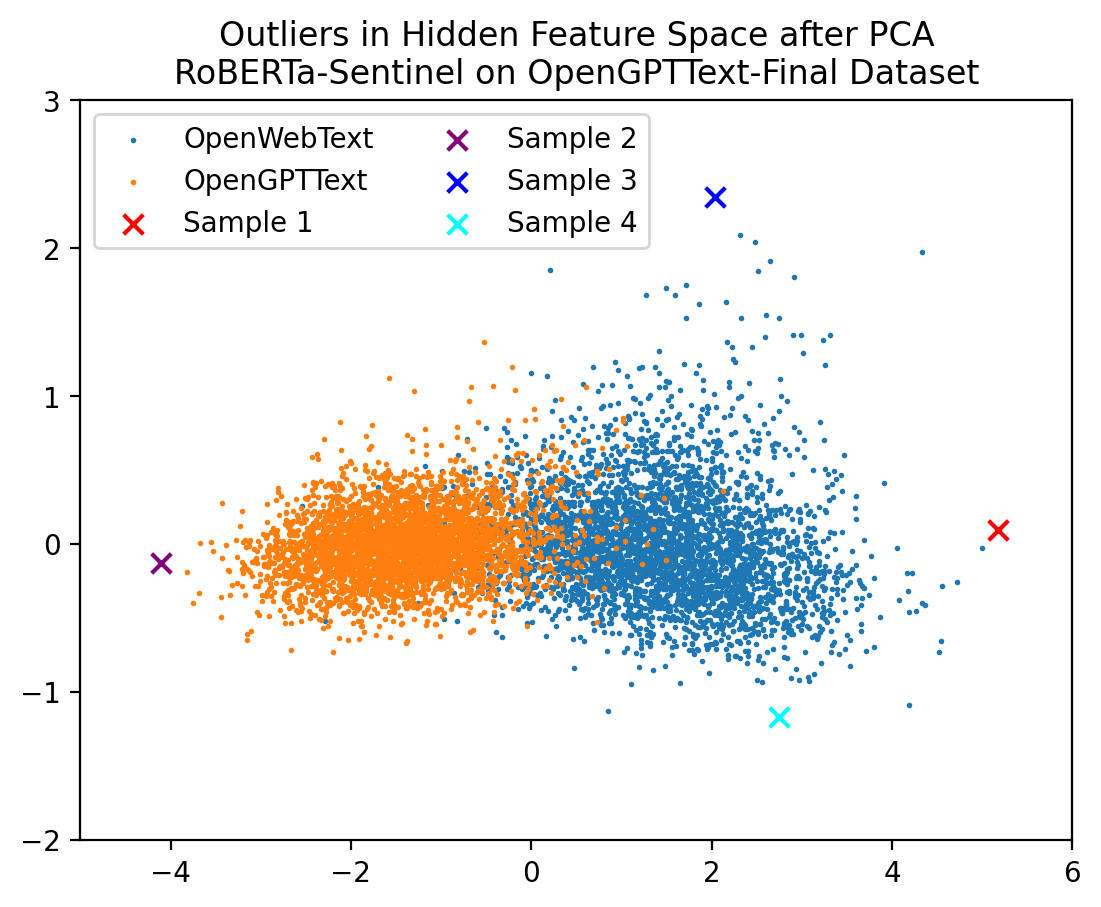

In [25]:
fig, ax = plot_pca(r_cmcd_pcas, f_cmcd_pcas, x_range=(-5, 6), y_range=(-2, 3))
ax.scatter(most_human_pca[0], most_human_pca[1], s=50, label="Sample 1", marker="x", c="red")
ax.scatter(most_gpt_pca[0], most_gpt_pca[1], s=50, label="Sample 2", marker="x", c="purple")
ax.scatter(most_top_pca[0], most_top_pca[1], s=50, label="Sample 3", marker="x", c="blue")
ax.scatter(most_bottom_pca[0], most_bottom_pca[1], s=50, label="Sample 4", marker="x", c="cyan")
ax.legend(ncol=2)
ax.set_title("Outliers in Hidden Feature Space after PCA\nRoBERTa-Sentinel on OpenGPTText-Final Dataset")
fig.savefig(Path(PATH_FIG, "pca_sampling_outliers.pdf"))

Observation

1. Sample 1 - Long text with many short lines (more newline)
2. Sample 2 - Short text with big paragraph (less newline)
3. Sample 3 - A list of developer tools from some website (meaningless)
4. Sample 4 - A short news report article

## Rephrasing Direction Analysis

In this section of analysis, we want to inspect how "rephrasing" moves the data point in our hidden feature space, and thus learn about how effective our model is.

First, we randomly sample 20 data pairs from our dataset.

In [107]:
cmcd_uids = [key[:-4] for key in cmcd_hiddens.keys() if key.endswith("-web")]
rand_uids = random.choices(cmcd_uids, k=20)

In [108]:
textPair = {uid:clean_dataset[uid] for uid in rand_uids}
human_pca = {uid:r_cmcd_pcas[cmcd_human_uids.index(uid + "-web")] for uid in rand_uids}
human_pca_arr = np.array([r_cmcd_pcas[cmcd_human_uids.index(uid + "-web")] for uid in rand_uids])

gpt_pca = {uid:f_cmcd_pcas[cmcd_gpt_uids.index(uid + "-gpt")] for uid in rand_uids}
gpt_pca_arr = np.array([f_cmcd_pcas[cmcd_gpt_uids.index(uid + "-gpt")] for uid in rand_uids])

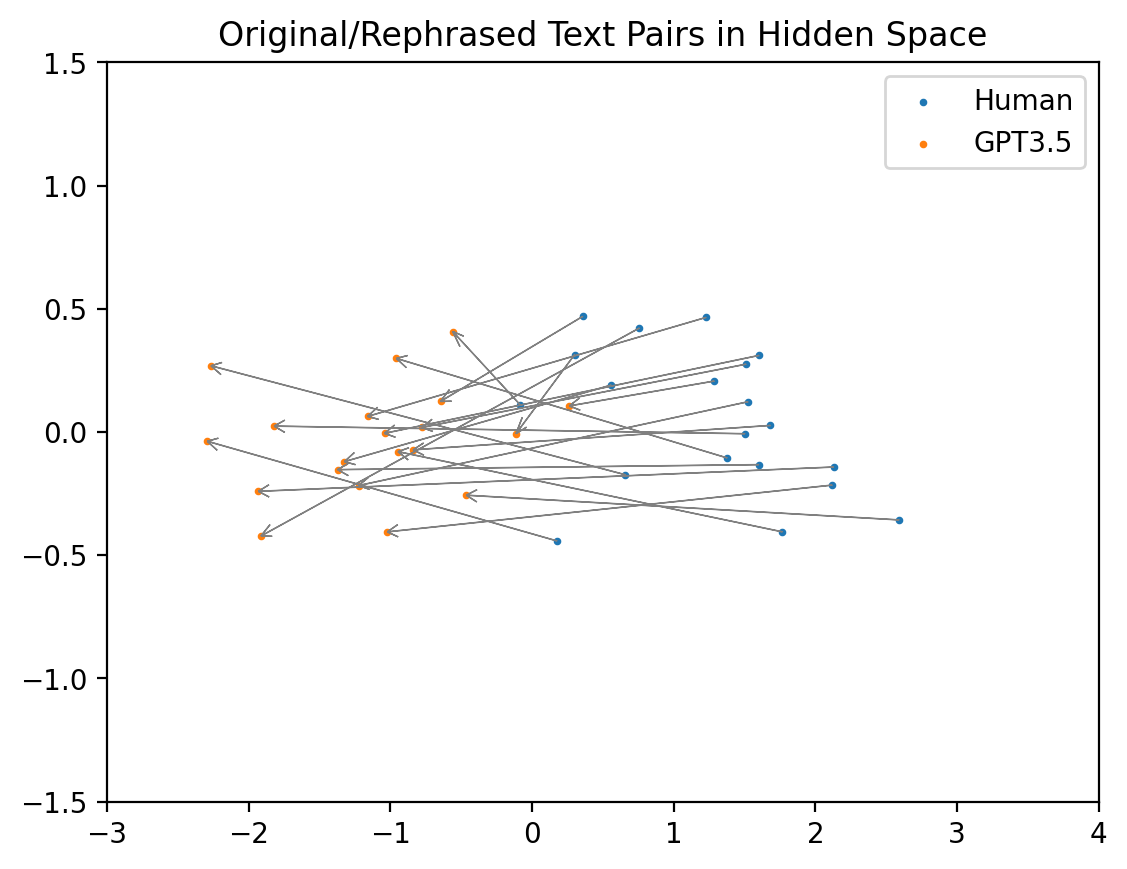

In [113]:
fig, ax = plot_pca(human_pca_arr, gpt_pca_arr, x_range=(-3, 4), y_range=(-1.5, 1.5))
for uid in rand_uids:
    start = human_pca[uid]
    end   = gpt_pca[uid]
    ax.arrow(
        start[0], start[1], end[0] - start[0], end[1] - start[1],
        head_width=0.05,
        fc='gray', ec='gray',
        linestyle='-', linewidth=0.5,
        length_includes_head=True, overhang=1
    )

ax.legend()
ax.set_title("Original/Rephrased Text Pairs in Hidden Space")
fig.savefig(Path(PATH_FIG, "original_rephrased_text_pairs.png"))

We can observe that the text after rephrasing left-shifted in the PCA projection of hidden space. This implies our model capture the hidden feature of GPT rephrasing implicitly.

## Recursive Rephrasing Analysis